<a href="https://colab.research.google.com/github/mohamed-yassine-benkhadda/Cloud_removal/blob/main/Cloud%20removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Task 1 : Image segmentation

## In this task we will build a model able to detect the occurrences of cloud in the given images and generate a mask for these clouds ☁

### Import libraries 🧰

In [122]:
import os
# from google.colab import drive
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from numpy import vstack
import torch.nn as nn
from torch.optim import Adam,Adagrad
from torch.nn import BCELoss
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.optim import SGD
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re
import random
import math
from datetime import datetime

### Download data from Kaggle ⬇
The data we will use for this task is provided by kaggle : 
https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images

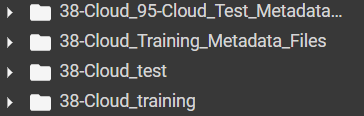

In [2]:
# Connect to Google Drive
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [ ]:
# Locate the json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images --unzip

In [ ]:
# !rm -d 38-Cloud_95-Cloud_Test_Metadata_Files

### Define the dataset class 📪

In [3]:
# define random seed
random.seed(42)

In [4]:
class _Data(Dataset):
  def __init__(self, files):
      self.files = files
      self.images = []
      for f in files:
        try:
          pic_red = cv2.imread(str(f["red"]))
          pic_red = cv2.cvtColor(pic_red, cv2.COLOR_BGR2GRAY)
          pic_green = cv2.imread(str(f["green"]))
          pic_green = cv2.cvtColor(pic_green, cv2.COLOR_BGR2GRAY)
          pic_blue = cv2.imread(str(f["blue"]))
          pic_blue = cv2.cvtColor(pic_blue, cv2.COLOR_BGR2GRAY)
          pic_gt = cv2.imread(str(f["gt"]))
          pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
          pic_nir = cv2.imread(str(f["nir"]))
          pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
          pic = (np.dstack((pic_green,pic_blue,pic_red,pic_nir))).astype(np.float32)
          to_tensor = transforms.ToTensor()
          t1 = to_tensor(pic)
          t2 = to_tensor(pic_gt)
          self.images.append((pic,pic_gt))
        except:
          print("here")
      print(f"pic : {t1.shape} & pic_gt : {t2.shape}")
  def __getitem__(self,i):
      return self.images[i]     

  def __len__(self):
      return len(self.images)   

In [5]:
from osgeo import gdal

ModuleNotFoundError: No module named 'osgeo'

In [6]:
!ls ../input/38cloud-cloud-segmentation-in-satellite-images

38-Cloud_95-Cloud_Test_Metadata_Files  38-Cloud_training
38-Cloud_Training_Metadata_Files       bibtex.txt
38-Cloud_test			       training_patches_38-cloud_nonempty.csv


In [7]:
# Dataset Class
class CloudDataset(Dataset):
    def __init__(self, r_dir, base_dir,train=True,pytorch=True):
        super().__init__()
        self.files = []
        for f in os.listdir(base_dir/r_dir):
            pattern = ".+(LC.*)"
            x = re.search(pattern, f)
            if train:
              self.files.append({
                  "red" : base_dir/"train_red"/f,
                  "green" : base_dir/"train_green"/f.replace("red","green"),
                  "blue" : base_dir/"train_blue"/f.replace("red","blue"),
                  "nir" : base_dir/"train_nir"/f.replace("red","nir"),
                  "gt" : base_dir/"train_gt"/f.replace("red","gt"),
              })
            else:
              self.files.append({
                  "red" : base_dir/"test_red"/f,
                  "green" : base_dir/"test_green"/f.replace("red","green"),
                  "blue" : base_dir/"test_blue"/f.replace("red","blue"),
                  "nir" : base_dir/"test_nir"/f.replace("red","nir"),
                  "gt" : base_dir/"test_gt"/f.replace("red","gt"),
              })
        
    def split_train_test(self, ratio = 0.7):
        self.shuffle()
        elements = len(self.files)
        files = self.files[:math.ceil(elements * 0.1)]
        middle = int(len(files) * ratio)
        self.train_files = files[:middle]
        self.test_files = files[middle:]         
        return self.train_files,self.test_files
                                       
    def __len__(self):
        return len(self.files)

    def __getitem__(self,i):
      pic_red = cv2.imread(str(self.files[i]["red"]))
      _scale = 10000
      # pic_red = gdal.Open(str(self.files[i]["red"])).ReadAsArray() / _scale
      # pic_green = gdal.Open(str(self.files[i]["green"])).ReadAsArray() / _scale
      # pic_blue = gdal.Open(str(self.files[i]["blue"])).ReadAsArray() / _scale
      # pic_nir = gdal.Open(str(self.files[i]["nir"])).ReadAsArray() / _scale
      # pic_gt = gdal.Open(str(self.files[i]["gt"])).ReadAsArray() / _scale
      pic_red = cv2.cvtColor(pic_red, cv2.COLOR_BGR2GRAY)
      pic_green = cv2.imread(str(self.files[i]["green"]))
      pic_green = cv2.cvtColor(pic_green, cv2.COLOR_BGR2GRAY)
      pic_blue = cv2.imread(str(self.files[i]["blue"]))
      pic_blue = cv2.cvtColor(pic_blue, cv2.COLOR_BGR2GRAY)
      pic_gt = cv2.imread(str(self.files[i]["gt"]))
      pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
      pic_nir = cv2.imread(str(self.files[i]["nir"]))
      pic_nir = cv2.cvtColor(pic_nir, cv2.COLOR_BGR2GRAY)
      pic = (np.dstack((pic_green,pic_blue,pic_red))) .astype(np.uint8)
      return pic,pic_gt

    def shuffle(self):
        return random.shuffle(self.files)

In [8]:
# Instantiate train and test data
base_train = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
base_test = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_test')
data = CloudDataset(base_dir=base_train,r_dir='train_red')
# test_data = CloudDataset(base_dir=base_test,r_dir='test_red',train=False)

In [9]:
# Shuffle data
data.shuffle()

In [10]:
# Split data
train_data, test_data = data.split_train_test(ratio = 0.7)
del data

In [11]:
train_data = _Data(train_data)
test_data = _Data(test_data)

pic : torch.Size([4, 384, 384]) & pic_gt : torch.Size([1, 384, 384])
pic : torch.Size([4, 384, 384]) & pic_gt : torch.Size([1, 384, 384])


### Build the model 💻
For this task we will use U-Net model
![](https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png)


To build the model we will create Double convs objects and try to connect them so as to build the final model

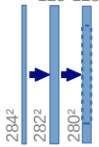

In [12]:
# Double Conv
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [13]:
# Build the Unet Model
class UNET(nn.Module):
    def __init__(
            self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_connections = []
        x = x.resize_(1,4,384,384)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [124]:
#Instantiate the model
unet = UNET()

### Train the model

In [15]:
test_data[0][0].shape

(384, 384, 4)

In [16]:
loss_fn = nn.SmoothL1Loss()
optimizer = Adam(unet.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(unet.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    unet.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in DataLoader(test_data,batch_size=1,shuffle=True):
            images, labels = data
            images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
            # run the unet on the test set to predict labels
            outputs = unet(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item() / 384**2

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The unet will be running on", device, "device")
    # Convert unet parameters and buffers to CPU or Cuda
    unet.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        print(f"{epoch+1} / {num_epochs}")
        for i, (images, labels) in enumerate(DataLoader(train_data,batch_size=10,shuffle=True), 0):
            batch_size = images.shape[0]
            out = []
            for j in range(batch_size):
              images = images.to("cuda:0")
              labels = labels.to("cuda:0")
              outputs = unet(images[j])
              out.append(outputs)
            pic = torch.stack(out)
            loss = loss_fn(pic.reshape(3,384,384).float(), labels.float())
            del pic
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 9:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [126]:
learning_rate = 1e-2
optimizer = Adagrad(unet.parameters(), lr=learning_rate, weight_decay=0.0001)
n_epochs = 100
loss = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet.to(device)
l = []
for epoch in range(n_epochs):
  running_loss = 0.0
  for (imgs, labels) in DataLoader(train_data,batch_size=12,shuffle=True):
    batch_size = imgs.shape[0]
    out = []
    for j in range(batch_size):
      imgs = imgs.to("cuda:0")
      labels = labels.to("cuda:0")
      outputs = unet(imgs[j])
      out.append(outputs)
    pic = torch.stack(out)
    del out
    loss = loss_fn(pic.reshape(12,384,384).float(), labels.float())
    del pic
    del labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss
  l.append(float(running_loss))
  print("Epoch: %d, Loss: %f" % (epoch, float(running_loss)))

Epoch: 0, Loss: 3761.166260
Epoch: 1, Loss: 3758.973633
Epoch: 2, Loss: 3758.066895
Epoch: 3, Loss: 3757.392822
Epoch: 4, Loss: 3757.059570
Epoch: 5, Loss: 3756.858887
Epoch: 6, Loss: 3756.645752
Epoch: 7, Loss: 3756.446045
Epoch: 8, Loss: 3756.295898
Epoch: 9, Loss: 3756.116699
Epoch: 10, Loss: 3755.931885
Epoch: 11, Loss: 3755.774902
Epoch: 12, Loss: 3755.802979
Epoch: 13, Loss: 3755.672607
Epoch: 14, Loss: 3755.507812
Epoch: 15, Loss: 3755.507812
Epoch: 16, Loss: 3755.404053
Epoch: 17, Loss: 3755.305908
Epoch: 18, Loss: 3755.266602
Epoch: 19, Loss: 3755.178223
Epoch: 20, Loss: 3755.164795
Epoch: 21, Loss: 3755.084473
Epoch: 22, Loss: 3755.021240
Epoch: 23, Loss: 3755.042969
Epoch: 24, Loss: 3754.938232
Epoch: 25, Loss: 3754.888428
Epoch: 26, Loss: 3754.856934
Epoch: 27, Loss: 3754.815674
Epoch: 28, Loss: 3754.892822
Epoch: 29, Loss: 3754.750488
Epoch: 30, Loss: 3754.775879
Epoch: 31, Loss: 3754.676758
Epoch: 32, Loss: 3754.675293
Epoch: 33, Loss: 3754.679199
Epoch: 34, Loss: 3754.58

In [136]:
tensor = torch.from_numpy(test_data[53][0])
tensor = tensor.cuda()
out = unet(tensor)
tensor2 = torch.from_numpy(test_data[53][1])
tensor2 = tensor2.cuda()

(array([25260., 18348., 17629., 16847., 15531., 13788., 12672., 11084.,
         9470.,  6827.]),
 array([0.        , 0.09998425, 0.1999685 , 0.29995275, 0.399937  ,
        0.49992126, 0.5999055 , 0.6998898 , 0.799874  , 0.8998583 ,
        0.9998425 ], dtype=float32),
 <BarContainer object of 10 artists>)

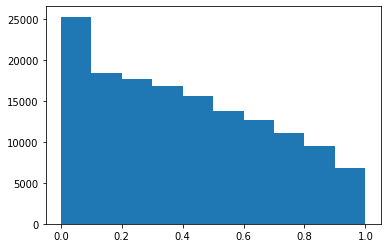

In [137]:
out_cv2 = out.reshape(384,384).cpu().detach().numpy()
# out_cv2 = cv2.imread(out_cv2)
# out_cv2 = Image.fromarray(out_cv2)
# out_cv2 = cv2.imread(out_cv2)
# out_cv2.show()
# out_cv2 = cv2.cvtColor(out_cv2, cv2.COLOR_BGR2GRAY)
lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
# lab_cv2 = Image.fromarray(lab_cv2)
plt.hist(out_cv2.flatten())
# plt.imshow(out_cv2 > 0.9)


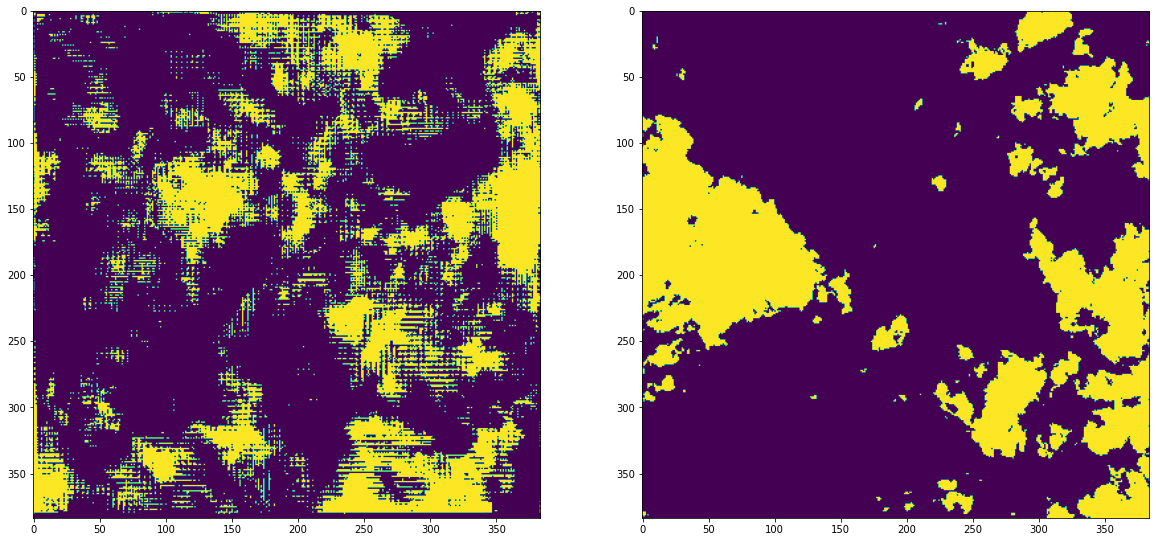

In [141]:
plt.figure(figsize=(20,20))
out_cv2 = out.reshape(384,384).cpu().detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(out_cv2>0.6)


lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
plt.subplot(1, 2, 2)
plt.imshow(lab_cv2)
plt.show()

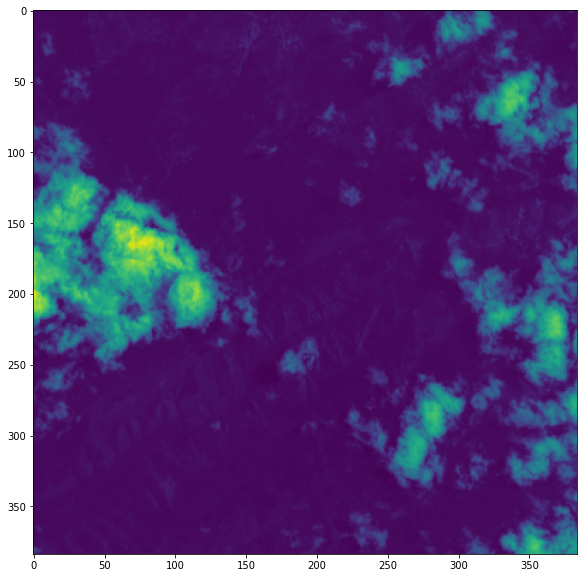

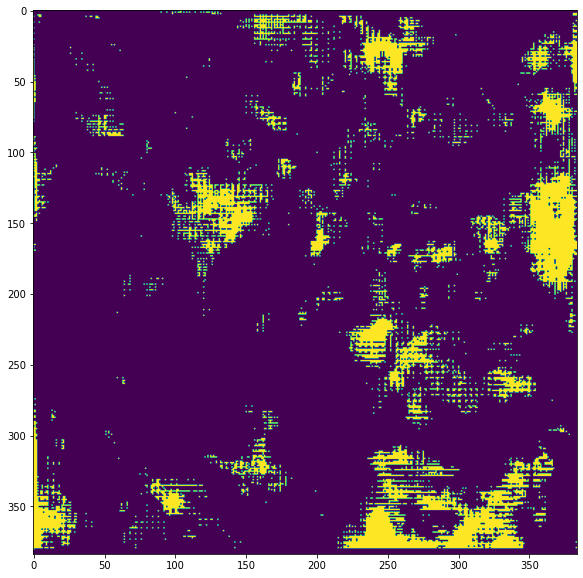

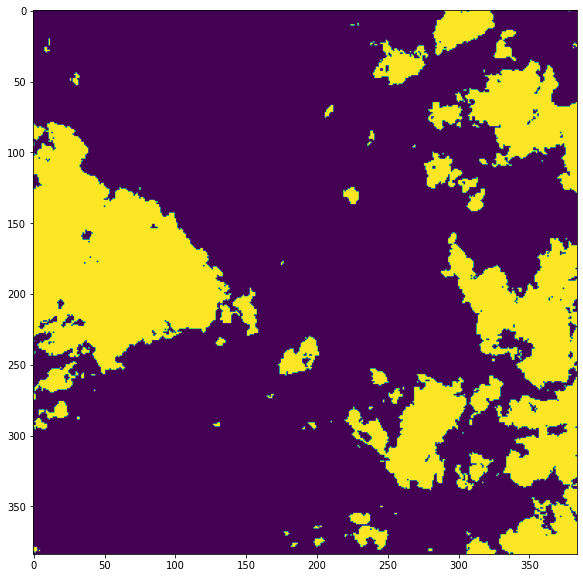

In [142]:
plt.figure(figsize=(10,10))
tensor_cv2 = tensor.reshape(384,384,4).cpu().detach().numpy()
plt.imshow(tensor_cv2[:,:,1])


plt.figure(figsize=(10,10))
tensor_cv2 = tensor.reshape(384,384,4).cpu().detach().numpy()
plt.imshow(out_cv2>.8)

plt.figure(figsize=(10,10))
lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
plt.imshow(lab_cv2)
plt.show()

In [ ]:
a = []
for i in range(100000000000000000000):
  a.append(i)

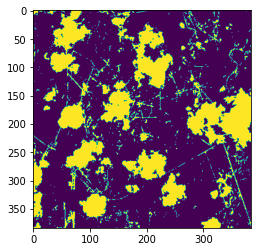

In [156]:
plt.imshow((tensor_cv2[:,:,1]-out_cv2)>45)

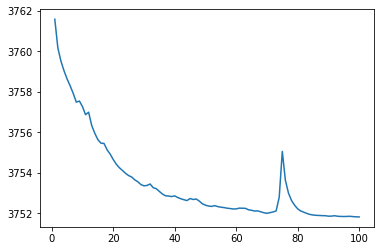

In [89]:
x = np.linspace(1,100,100)
plt.plot(x,l)

In [165]:
import seaborn as sns

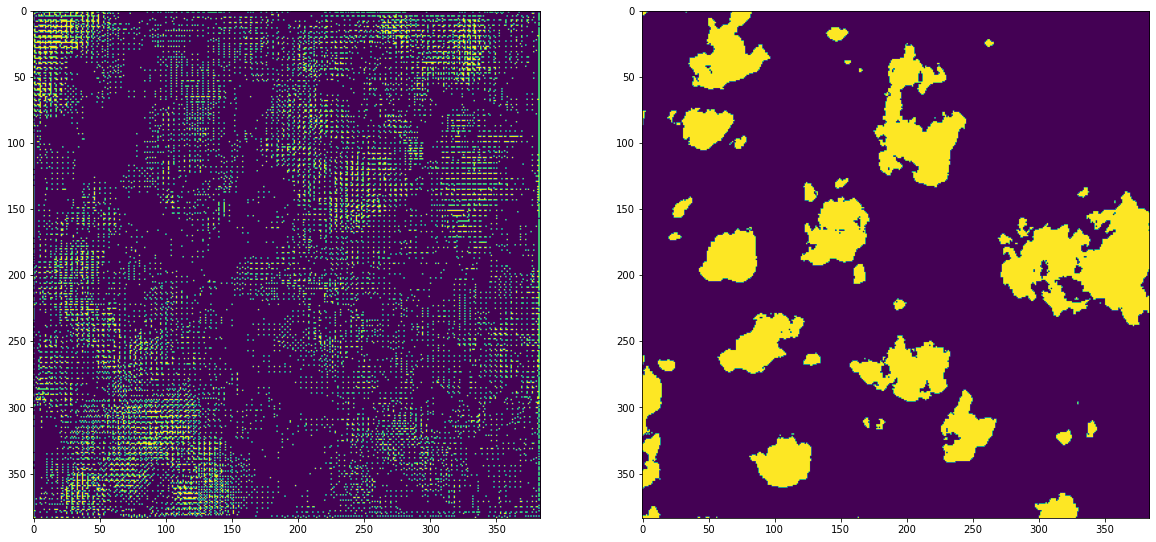

In [27]:
plt.figure(figsize=(20,20))
out_cv2 = out.reshape(384,384).cpu().detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(out_cv2>.55)


lab_cv2 = tensor2.reshape(384,384).cpu().detach().numpy()
plt.subplot(1, 2, 2)
plt.imshow(lab_cv2)
plt.show()